# add language model stuff 11-8-19

In [1]:
import pickle
import sys

In [2]:
dir_path = '/home/david/GIT/cs481-senior-design/s19/'
sys.path.append(dir_path)

import LanguageModel

dir_path = '/home/david/GIT/cs481-senior-design/s19/'
with open(dir_path+'language-model.pickle', 'rb') as handle:
    predModel = pickle.load(handle) #trying to load a LanguageModel type    

def predict(robot):
    preds = []
    for i in range(len(languageFeed)):
        currentImg = languageFeed.pop()
        preds.append(predModel.predictImageWord(currentImg))
    preds = [item[0] for item in preds] #remove probability number in tuple
    prediction = collections.Counter(preds).most_common(1)[0][0]
    robot.say_text(prediction).wait_for_completed()

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/david/anaconda3/envs/cozmo/lib/python3.7/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])
/home/david/anaconda3/envs/cozmo/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/david/anaconda3/envs/cozmo/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.2 when using version 0.21.3. This might lead to breaking code or inv

In [3]:
dir_path = '/home/david/GIT/language-acquisition/'
sys.path.append(dir_path)

import matplotlib
# matplotlib.use("Qt5Agg") #Makes imshow work on mac
from matplotlib import pyplot as plt
from classes.mask_rcnn import MaskRCNN
#from Model import Model, draw_boxes

import queue
import time
import threading
import numpy as np
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/home/david/anaconda3/envs/cozmo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/david/anaconda3/envs/cozmo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/david/anaconda3/envs/cozmo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/david/anaconda3/envs/cozmo/lib/python3.7/site-

In [4]:
import os

obj_det_path = "/home/david/anaconda3/envs/cozmo/lib/python3.7/site-packages/tensorflow/models/research/object_detection/"

# faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
MODEL_NAME = obj_det_path + 'd2s_model'

path = MODEL_NAME + '/frozen_inference_graph.pb'
image_dimensions = (240, 320, 3)
model = MaskRCNN(path, image_dimensions)

PATH_TO_LABELS = os.path.join(obj_det_path + 'd2s_model', 'label_map.pbtxt')

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [5]:
import datetime
sys.path.append('/home/david/GIT/cozmo-python-sdk/')
sys.path.append('/home/david/GIT/cozmo-python-sdk/src')
sys.path.append('/home/david/GIT/cozmo-python-sdk/src/cozmo')

from src.cozmo.util import degrees, Angle, distance_mm, speed_mmps
from src import cozmo

/home/david/anaconda3/envs/cozmo/lib/python3.7/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [6]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

def handle_image(evt, obj=None, tap_count=None,  **kwargs):
    try:
        if(imageQueue.empty()): # 
            imageQueue.put_nowait(evt.image)
    except queue.Full:
        pass

def configure_camera(robot, exposure_amount, gain_amount, color):
    robot.camera.color_image_enabled = color
    # Lerp exposure between min and max times
    min_exposure = robot.camera.config.min_exposure_time_ms
    max_exposure = robot.camera.config.max_exposure_time_ms
    exposure_time = (1-exposure_amount)*min_exposure + exposure_amount*max_exposure
    # Lerp gain
    min_gain = robot.camera.config.min_gain
    max_gain = robot.camera.config.max_gain
    actual_gain = (1-gain_amount)*min_gain + gain_amount*max_gain
    robot.camera.set_manual_exposure(exposure_time, actual_gain)

def detect_object(robot, minimum_threshold=0.10):
    '''
    run object detection on images from imageQueue
    returns: populates objectQueue with Object data. 
    '''
    print('Detect Images started')
    counter = 0
    while(True):
        if(not imageQueue.empty()): 
            try:
                img = imageQueue.get()
                image_np = load_image_into_numpy_array(img)
                output_dict = model.detect(image_np)

                indices = [list(output_dict['detection_scores']).index(o) 
                           for o in output_dict['detection_scores'] 
                           if o > minimum_threshold]
                if len(indices) > 0 and objQueue.empty():    
                    for i in range(len(indices)):
                        boxes = [output_dict['detection_boxes'][i] for i in indices]
                        b = boxes[i]
                        real_obj = obj_check(b)
                        if not real_obj[0]: 
                            continue
                        else: 
                            classes = [output_dict['detection_classes'][i] for i in indices]
                            scores = [output_dict['detection_scores'][i] for i in indices]
                            bestObj_i = i 
                            box = boxes[bestObj_i]
                            score = scores[bestObj_i]
                            label = classes[bestObj_i]

                            if objQueue.empty():
                                plt.clf() # We need to clear the plot so that we are not plotting every image each iteration. 
                                # (If we don't we will get increasing delay)
                                objQueue.put_nowait(box)
                                
                                # add image to the language feed
                                crop_ADD_image(box, img.copy())
                                
                                vis_util.visualize_boxes_and_labels_on_image_array(
                                    image_np,
                                    output_dict['detection_boxes'],
                                    output_dict['detection_classes'],
                                    output_dict['detection_scores'],
                                    category_index,
                                    use_normalized_coordinates=True,
                                    min_score_thresh=minimum_threshold,
                                    line_thickness=8,
                                    max_boxes_to_draw=3)
                                plt.imshow(image_np)
                                plt.pause(0.001) # imshow needs time to plot the image. Need this to display the image
                                
            except queue.Empty:
                pass

In [8]:
def obj_check(go_box):
    '''
    tf documentation is wrong --
    order is not: [ymin, ymax, xmin, xmax]
    order IS: [ymin, xmin, ymax, xmax]
    '''
    ymin = go_box[0]
    xmin = go_box[1]
    ymax = go_box[2]
    xmax = go_box[3]
    height = ymax - ymin
    width = xmax - xmin
    area = height * width    
    x_center = (width/2) + xmin
    y_center = (height/2) + ymin
    # the condition that determines if a bounding box contains an object
    if area > 0.08: 
#         print('check failed!')
        return (False, y_center, x_center)
    else: 
#         print('check passed')
        return (True, y_center, x_center)

In [9]:
import PIL
from PIL import ImageDraw, ImageFont, Image
def crop_ADD_image(box, img:PIL.Image):
    '''
    given a likely object; 
    crop box --> to conv-net --> lang model
    OR, if predicting, crop box --> conv-net --> retrieve prediction + lang model
    '''
    # 8-10 from s19/Model.py
    size = 224
    
    img_resized = img.resize(size=(size, size))    
    cleanImg = img_resized.copy();
    
    bottom = box[0] * 224
    left = box[1] * 224
    top = box[2] * 224
    right  = box[3] * 224
    # these box coordinates are not appropriate for the formatting task...
    
    formattedBox = (int(left), int(bottom), int(right), int(top)) # coordinates need to be corrected for crop
    
    print('crop here:', formattedBox)
    print('clean image type:', type(cleanImg))
    
    croppedImg = cleanImg.crop(formattedBox)
    croppedImg.load()
    croppedImg = np.array(croppedImg) 
    croppedImg = croppedImg[:, :, ::-1].copy()
    languageFeed.append(croppedImg) 

In [10]:
def find_coordinates(go_box):
    real_obj = obj_check(go_box)    
    x_center = real_obj[2]
    y_center = real_obj[1]
    print('y:', y_center, 'x:', x_center)
    if not real_obj[0]: # break 'go_to' loop
        drive_dist = 1000 
        turn_angle = 1000
    else:
        # we want x_center to be 0.5, turn right -> (-) / turn left -> (+)
        if x_center > 0.56 or x_center < 0.44:
            x_diff = x_center - 0.5
            turn_angle = (x_diff * (-50)) / 2 
        else: turn_angle = 0 # break 'go_to' loop
        # we want y-center to be = 0.42, (-) -> backwards, (+) -> forwards   
        if y_center > 0.48 or y_center < 0.36:
            y_diff = y_center - 0.42
            # need to account for parallax -- things far away approach slowly; things close up approach quickly
            base = y_diff * (-10)
            drive_dist = np.power(base,4)
        else: drive_dist = 0 # break 'go_to' loop
    return drive_dist, turn_angle

def go_to_obj(robot):    
    last_drive = 1000
    last_turn = 1000
    while True:
        if not objQueue.empty():
            box = objQueue.get()
            print("go to ", box)
            drive_dist, turn_angle = find_coordinates(box)
            print('turned ', turn_angle, 'degrees', '/ drove', drive_dist,'mm')
            # these conditions break 'go_to' loop
            if drive_dist > last_drive: break
            elif turn_angle > last_turn: break
            if turn_angle == 0 and drive_dist == 0: break
            robot.turn_in_place(degrees(turn_angle),in_parallel=True)
            robot.wait_for_all_actions_completed()  
            last_turn = turn_angle
            
            robot.drive_straight(distance_mm(drive_dist), speed_mmps(40), should_play_anim=False, in_parallel=True)
            last_drive = drive_dist
            robot.wait_for_all_actions_completed()  
    print('Stop going to object')
    return drive_dist, turn_angle 

In [11]:
import random
def find_object(robot):
    print('Find objects started')
    
    confidence = 0 # added for language prediction
    find = True
    while find:
        if objQueue.empty():
#             robot.turn_in_place(degrees(360), speed=Angle(0.3), accel=Angle(0.3))
            robot.drive_wheels(l_wheel_speed=-10, r_wheel_speed=10)
        else:
            robot.stop_all_motors()
            robot.wait_for_all_actions_completed()
            # the 'go to object reorientation loop'
            predicting = False
            drive, turn = go_to_obj(robot)
            if drive == 0 and turn == 0:  
                print('Object found!')
                predict(robot)
                find = False
            else: #drive == 1000 and turn == 1000
                print('find object failed') 
                predict(robot)
                # emote CONFUSED
                pass
            print('return to object search')

#     predicting = True # predict in this instance

In [12]:
def cozmo_program(robot: cozmo.robot.Robot):
    print('starting pose',robot.pose)
    robot.clear_idle_animation()
    robot.stop_freeplay_behaviors()
    robot.set_idle_animation(cozmo.anim.Triggers.NeutralFace)   
    robot.set_lift_height(1.0).wait_for_completed()
    robot.set_head_angle(cozmo.robot.MIN_HEAD_ANGLE).wait_for_completed()

    exposure_amount = 0.1 # Range: [0,1]
    gain_amount = 1.0 # Range: [0,1]
    color = True
    configure_camera(robot, exposure_amount, gain_amount, color)
    
    robot.add_event_handler(cozmo.camera.EvtNewRawCameraImage, handle_image)
    print("Added event handler")
    
    minimum_threshold = 0.10
    
    threading.Thread(target=find_object, args=(robot,)).start()
    threading.Thread(target=detect_object, args=(robot,minimum_threshold,)).start() # 
    
    while True:
        time.sleep(0.1)

In [13]:
%matplotlib inline

2019-12-11 14:22:36,861 cozmo.general INFO     App connection established. sdk_version=1.4.11.dev0 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2019-12-11 14:22:36,861 cozmo.general INFO     App connection established. sdk_version=1.4.11.dev0 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2019-12-11 14:22:36,960 cozmo.general INFO     Found robot id=1
2019-12-11 14:22:36,960 cozmo.general INFO     Found robot id=1
2019-12-11 14:22:37,189 cozmo.general INFO     Connected to Android device serial=03160355293b2004
2019-12-11 14:22:37,189 cozmo.general INFO     Connected to Android device serial=03160355293b2004
2019-12-11 14:22:37,306 cozmo.general INFO     Robot id=1 serial=024086a7 initialized OK
2019-12-11 14:22:37,306 cozmo.general INFO     Robot id=1 serial=024086a7 initialized OK
2019-12-11 14:22:37,676 cozmo.general INFO     Sending abort request for all actions
2019-12-11 14:22:37,676 cozmo.general INFO     Sending abort request for all actions


starting pose <Pose <Position x: 0.00 y: 0.00 z: 0.00> <Quaternion q0: 0.99 q1: 0.00 q2: 0.00 q3: -0.15 (angle_z: <Angle -0.30 radians (-17.45 degrees)>)> origin_id=93>


Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/david/GIT/cozmo-python-sdk/src/cozmo/tkview.py", line 164, in _repeat_draw_frame
    self._draw_frame()
  File "/home/david/GIT/cozmo-python-sdk/src/cozmo/tkview.py", line 158, in _draw_frame
    self.label.configure(image=photoImage)
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/tkinter/__init__.py", line 1476, in _configure
    self.tk.call(_flatten((self._w, cmd)) + self._options(cnf))
_tkinter.TclError: image "pyimage487" doesn't exist


Added event handler
Find objects started
Detect Images started
crop here: (180, 2, 224, 20)
clean image type: <class 'PIL.Image.Image'>
go to  [0.0092762  0.8056385  0.09055956 1.        ]
y: 0.04991787951439619 x: 0.9028192460536957
turned  -10.070481151342392 degrees / drove 187.5825413598492 mm
crop here: (180, 2, 224, 19)
clean image type: <class 'PIL.Image.Image'>


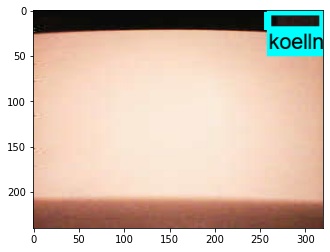

IndexError: list index out of range

<Figure size 432x288 with 1 Axes>

go to  [0.01052711 0.8064858  0.08762731 1.        ]
y: 0.04907721187919378 x: 0.9032428860664368
turned  -10.08107215166092 degrees / drove 189.2927856366985 mm
Stop going to object
find object failed


Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/david/GIT/cozmo-python-sdk/src/cozmo/tkview.py", line 67, in _thread_call_dispatch
    self.after(50, self._thread_call_dispatch)
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/tkinter/__init__.py", line 757, in after
    return self.tk.call('after', ms, name)
KeyboardInterrupt
Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/david/anaconda3/envs/cozmo/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-11-3423345e7307>", line 23, in find_object
    predict(ro

In [15]:
import collections
imageQueue = queue.Queue(maxsize=1)
objQueue = queue.Queue(maxsize=1)
languageFeed = collections.deque(maxlen=8)

cozmo.run_program(cozmo_program, use_viewer=True)

______________________

**Good neutral animations?**

    # DroneModeIdle, 161
    # NeutralFace, 326
    # OnboardingIdle, 362
    # VC_NoFollowupCommand_NoFace, 549